In the locally weighted model, we have proved the similarity between data does have a positive effect on predictions.<br>
However, to find the closest k points for one query point, we have to iterate the whole dataset at least k times, which can be really expensive. We cannot rely on this method in production.<br>
To save computation time, here we are going to refer to Local Sensitive Hashing(LSH)<br>
Read https://en.wikipedia.org/wiki/Locality-sensitive_hashing for more information<br><br>

The basic idea behind LSH is that we want to narrow down our searching scope quickly and find the closest neighbors in a smal group of data. To achieve that goal, we divide data into n groups, to determine one query data point belongs to this group or not, we use a random generated vector with the same shape as the query point, calcualte the dot product between the random vector and the query point, if it's greater than 0, we say this point belongs to this group, otherwise it doesn't. (Actually random vector turns out to be a very good initialization). We generate n different random vector and calculate dot product for each, then we can get a vector of n 0/1 variables. 

In [72]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import combinations, combinations_with_replacement
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
import math
from copy import copy

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 2000
%matplotlib inline

Read data

In [3]:
df = pd.read_csv('train.csv')
del df['id']

In [4]:
dummy_df = pd.get_dummies(df)
y = dummy_df['loss'].values
del dummy_df['loss']

In [5]:
zscore_df = (dummy_df - dummy_df.mean()) / dummy_df.std()
zscore_df = zscore_df.values

In [6]:
def generate_random_vectors(num_vector, dim):
    """
    This function returns a sample from standard normal distribution
    """
    return np.random.randn(dim, num_vector)

In [7]:
def train_lsh(data, num_vector=16, seed=None):
    """
    LSH function
    """
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
    
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    table = {}
    
    bin_index_bits = (data.dot(random_vectors) >= 0)
    
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    for data_index, bin_index in enumerate(bin_indices):
        table.setdefault(bin_index, []).append(data_index)
        
    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vectors': num_vector}
    
    return model

Try to divide data into 32(2^5) groups

In [19]:
seed = 0
num_vector = 5
num_groups = np.power(2, num_vector)

In [20]:
# Check it out how fast it can be
model = train_lsh(zscore_df, num_vector, seed)

In [21]:
assert len(zscore_df) == len([item for sublist in model['table'].values() for item in sublist])

In [22]:
assert num_groups-1 == max(model['table'].keys())

Take a look at group counts distribution

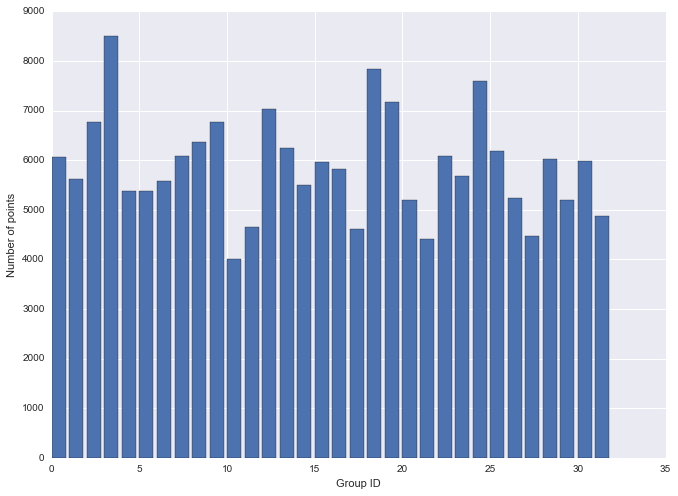

In [23]:
counts = {k: len(v) for k, v in model['table'].items()}
plt.figure(figsize=(11, 8))
plt.bar(counts.keys(), counts.values())
plt.xlabel('Group ID')
plt.ylabel('Number of points')

Looks good, they are distributed evenly, roughly of course

In [14]:
def calculate_average_similarity(group_1, group_2, self=False):
    """
    A function calculates the average of cosin similarity between two groups of data.
    It returns a float number.
    """
    if self:
        return (cosine_similarity(group_1, group_2).sum() - group_1.shape[0]) / (group_1.shape[0] * group_2.shape[0])
    return (cosine_similarity(group_1, group_2).sum()) / (group_1.shape[0] * group_2.shape[0])

Let's pick up 5 groups randomly and check their similiarity

In [25]:
interested_groups = [0, 13, 19, 24, 30]

In [46]:
def get_similarity_matrxi(data, model, interested_groups):
    num_groups = len(interested_groups)
    similarity_matrix = np.zeros(num_groups**2).reshape(num_groups, num_groups)
    for group_1, group_2 in combinations_with_replacement(interested_groups, 2):
        index_1 = interested_groups.index(group_1)
        index_2 = interested_groups.index(group_2)
        self = index_1 == index_2
        similarity_matrix[index_1, index_2] = calculate_average_similarity(
            data[model['table'][index_1]],
            data[model['table'][index_2]]
        )
    # make it symmetric
    return np.maximum(similarity_matrix, similarity_matrix.T)

In [45]:
similarity_matrix = get_similarity_matrxi(zscore_df, model, interested_groups)

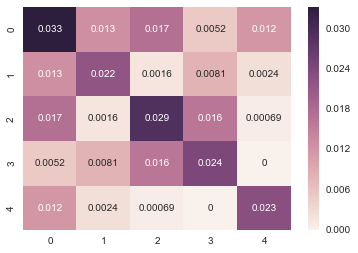

In [49]:
sns.heatmap(similarity_matrix, annot=True)

Indeed, the numbers on the diagonal are greater than others. This proves that our algorighm did put data with higher similarity in the same group. However, the similarities are general bad. You can tell from these really small values.  

It is bad because couple of reasons:<br>
1) Cosine similarity doesn't work for continuous variables. For example, if we have two normalized vectors [1, 1, 1] and [2, 2, 2], their cosine similarity is 1 which indicates these two vectors are exactly the same from a cosine measurement persepctive, however, apparently they are not.<br>
2) We shouldn't normalize categorical variables. It's the same reason as 1)

To fix the problem, we remove the normalization step for categorical variables, for continuous variables, we divide them into groups and use 0/1 to represnet them.

First let's take a look at continuous variables distributions.

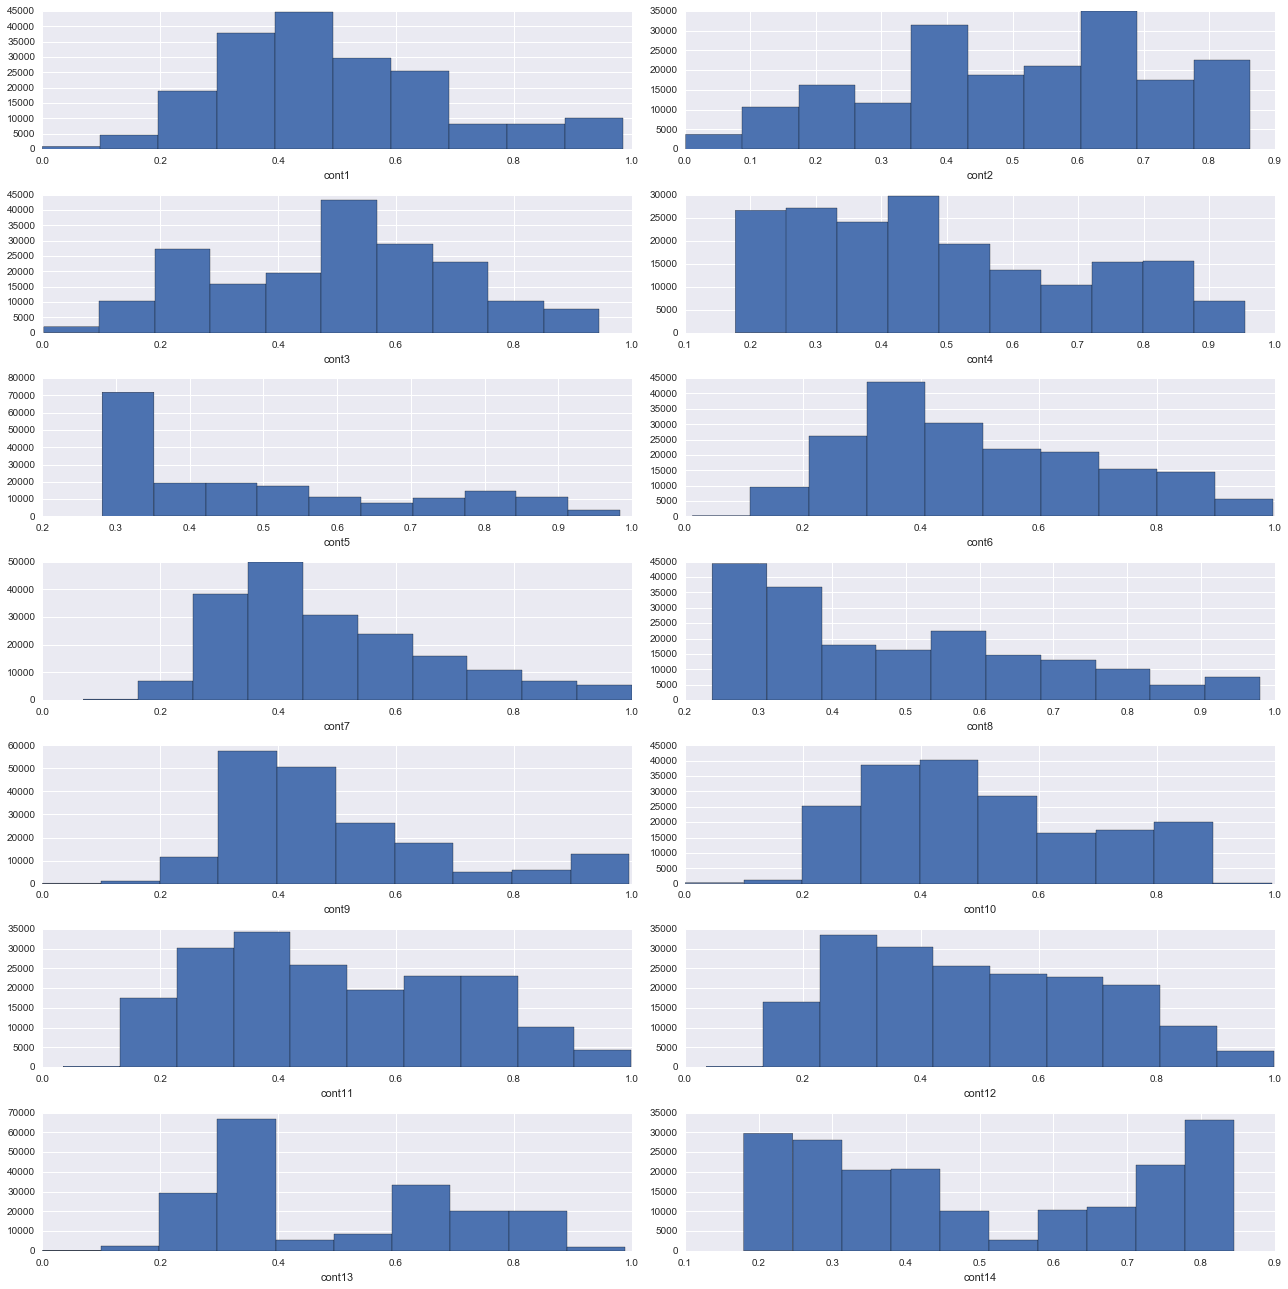

In [50]:
continuous_vars = [c for c in dummy_df.columns if c.startswith('cont')]
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(18, 18))
for i, c in enumerate(continuous_vars):
    sub = plt.subplot(7, 2, i+1)
    sub.set_xlabel(c)
    dummy_df[c].hist()

fig.tight_layout()

Apparently, most of them are not normal distributed, regardless of skweness, some continuous variables, e.g. cont14, if far away from a normal distribution. So the skweness corrections we took in linear regression were wrong either.

In [51]:
dummy_df[continuous_vars].describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848


All the continuous variables are from 0 to 1. We decide to divide each continous variables into 10 different groups.<br><br>
10 groups means we need 10 digits to represent all groups. For example, the first group contains all the data between 
[0, 0.1) will be expressed as 0000000001, the second group [0.1, 0.2) will be expressed as  0000000011 and etc. 
<br><br>This representation method can keep the relative value information in the dataset, which is what we want, for example, the cosine distance between 0000000111(Query point) and 0000000011(A), which is 0.18,  is shorter than the cosine distance between 0000000111 and 0000000001(B), which is 0.42. This makes senses because A represents data in group [0.1, 0.2) while B represents data in group [0, 0.1), the Query point is in group [0.2, 0.3), thus it should have shorter distance to A than B.

In [52]:
continuous_vars = [c for c in dummy_df.columns if c.startswith('cont')]

In [53]:
# Function divides continuous variables into groups
# TODO: there must be some better way
def continuous_to_groups(data, name):
    names = [name+'_{}'.format(i) for i in range(10, 0, -1)]
    decoded_data = []
    for d in data:
        group = d // 0.1 + 1
        zeros = np.zeros(10)
        zeros[-group:] = 1
        decoded_data.append(zeros)
    return pd.DataFrame(decoded_data, index=data.index, columns=names)

In [54]:
dummy_df_copy = dummy_df.copy()

In [55]:
original_size = len(dummy_df_copy)
for col in continuous_vars:
    decoded_df = continuous_to_groups(dummy_df_copy[col], col)
    dummy_df_copy = pd.merge(dummy_df_copy, decoded_df, how='inner', left_index=True, right_index=True)
    assert len(dummy_df_copy) == original_size

In [56]:
# remove the original continuous variables
for c in continuous_vars:
    del dummy_df_copy[c]

In [57]:
new_values = dummy_df_copy.values
new_model = train_lsh(new_values, num_vector, seed)

Take at a look the new group counts distribution.

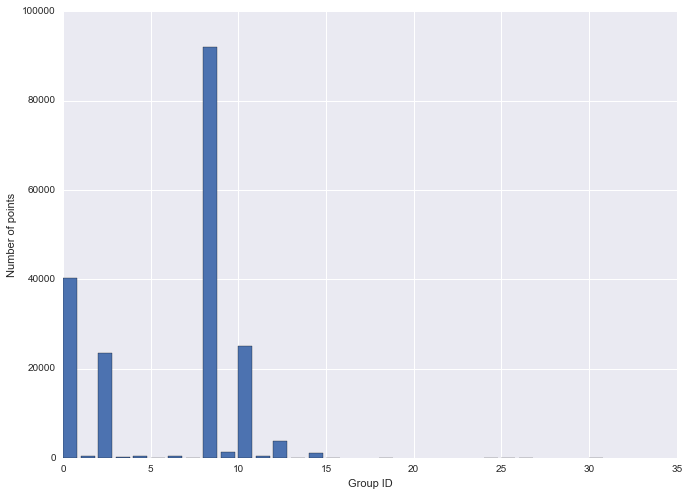

In [58]:
counts = {k: len(v) for k, v in new_model['table'].items()}
plt.figure(figsize=(11, 8))
plt.bar(counts.keys(), counts.values())
plt.xlabel('Group ID')
plt.ylabel('Number of points')

Compare this distribution graph to the previous one, we see cluster phenomenon in the new dataset. Groups 0, 2, 8, 10 contain roughly 95% data.

In [64]:
interested_groups = [0, 2, 8, 10, 12]

In [65]:
new_similarity_matrix = get_similarity_matrxi(new_values, new_model, interested_groups)

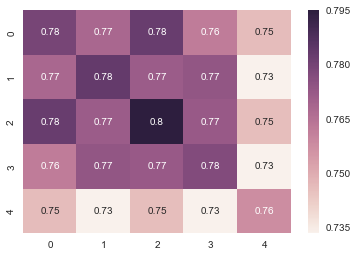

In [66]:
sns.heatmap(new_similarity_matrix, annot=True)

It's much better!

In [67]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = not alternate_bits[i]
        
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin])
    
    return candidate_set

In [162]:
def query(vec, model, k, max_search_radius):
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    candidate_set = set()
    for search_radius in range(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
        
    nearest_neighbors = pd.DataFrame({'id': list(candidate_set)})
    candidates = data[np.array(list(candidate_set)), :]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.nsmallest(k, 'distance'), len(candidate_set)

In [163]:
training_set = random.sample(range(1, new_values.shape[0]), 1000)

In [165]:
predictions_k = []
for index, i in enumerate(training_set):
    if index % 100 == 0:
        print(index)
    query_data = new_values[i]
    result, num_candidates_considered = query(query_data, new_model, k=1000, max_search_radius=3)
    prediction = []
    for k in [10, 100, 500, 1000]:
        index = result[1:1+k].id
        ys = y[index]
        weights = (1/ result[1:1+k].distance / sum(1/ result[1:1+k].distance)).values
        prediction.append(ys@weights)
    predictions_k.append(prediction)

0
100
200
300
400
500
600
700
800
900


In [215]:
predictions = np.array(predictions_k)
errors = np.sqrt(np.average((predictions - y[training_set].reshape(1000, 1))**2, axis=0))

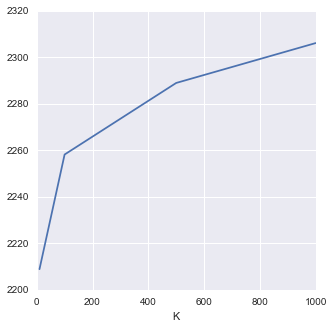

In [230]:
plt.figure(figsize=(5, 5))
fig = plt.plot([10, 100, 500, 1000], errors)
plt.xlabel('K')
plt.ylabel('')